# Przetwarzanie wstępne i czyszczenie danych

Spis treści:
1) ustalenie rodzajów atrybutów
2) wskazanie atrybutów celu
3) ustalenie i aplikacja strategii radzenia sobie z wartościami pustymi
4) identyfikacja i odrzucenie pomiarów odstających
5) wstępny wybór algorytmu eksploracji danych
6) przygotowanie atrybutów o konkretnym typie do eksploracji (normalizacja, zamiana na wektor, itd.)

**Import niezbędnych bibliotek**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

**Wczytanie i wyświetlenie danych**

In [ ]:
df = pd.read_csv("data/Telco_customer_churn.csv")

df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


### **1. Ustalenie rodzajów atrybutów**

**Wyświetlenie podstawowych statystyk**

In [ ]:
# Kategoryczne
num_categorical = len(df.select_dtypes(include=['category']).columns)

# Obiektowe (np. stringi)
num_object = len(df.select_dtypes(include=['object']).columns)

# Liczbowe
num_numerical = len(df.select_dtypes(include=[np.number]).columns)

print(f"Kategoryczne: {num_categorical}")
print(f"Obiektowe: {num_object}")
print(f"Liczbowe: {num_numerical}")
print(f"Łącznie: {len(df.columns)}")

Kategoryczne: 0
Obiektowe: 24
Liczbowe: 9
Łącznie: 33


**Atrybuty kategoryczne /

In [ ]:
df.describe(include=['object'])

,CustomerID,Country,State,City,Lat Long,Gender,Senior Citizen,Partner,Dependents,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Total Charges,Churn Label,Churn Reason
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043,7043,1869
unique,7043,1,1,1129,1652,2,2,2,2,2,...,3,3,3,3,3,2,4,6531,2,20
top,3186-AJIEK,United States,California,Los Angeles,"34.159534, -116.425984",Male,No,No,No,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No,Attitude of support person
freq,1,7043,7043,305,5,3555,5901,3641,5416,6361,...,3095,3473,2810,2785,3875,4171,2365,11,5174,192


Atrybut Total Charges został uznany za tekstowy bo przyjmuje 11 razy wartość spacji (' ') w csv.
Zamienimy tą wartość na 0.

In [ ]:
df.describe(include=[np.number])

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


**Atrybuty numeryczne**:

Count, Latitude, Longitude, Tenure Months, Monthly Charges, Total Charges, Churn Score, CLTV
Churn

**Atrybuty kategoryczne**:

Country, State, Multiple lines, Internet Service, Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies, Contract, Payment method, Churn Label, Churn Value,

**Atrybuty binarne**:

Gender, Senior Citizen, Partner, Dependents, Phone Service, Paperless Billing,

**Atrybuty tekstowe**:

CustomerID, City, Zip Code, Lat Long, Churn Reason

**Wybór atrybutów**

In [ ]:
len(df["Tenure Months"].unique())

73

Odrzucamy: CustomerID (nic nam nie daje), Count, Country (tylko jedna wartość), State (tylko jedna wartość), City, Lat long, Latitude, Longitude, Churn label (zostawimy churn value)

In [ ]:
print(len(df.columns))
df = df.drop(["CustomerID", "Count", "Country", "State", "City", "Lat Long", "Latitude", "Longitude", "Churn Label"], axis=1)
len(df.columns)

33


24

### **2. Wskazanie atrybutów celu**

Churn value.

### **3. Ustalenie i aplikacja strategii radzenia sobie z wartościami pustymi**

Wiersze z wartościami pustymi (NaN) należy odrzucić lub zastąpić wartości dla danego atrybutu np. średnią arytmetyczną lub medianą na danym atrybucie.

**Zastąpienie wartości pustych w kolumnie Churn reason wartością neutralną**

In [ ]:
df.astype('object').describe(include='all')

,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,...,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV,Churn Reason
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,...,7043,7043,7043,7043,7043.00,7043,7043,7043,7043,1869
unique,1652,2,2,2,2,73,2,3,3,3,...,3,3,2,4,1585.00,6531,2,85,3438,20
top,92284,Male,No,No,No,1,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,20.05,20.2,0,80,5546,Attitude of support person
freq,5,3555,5901,3641,5416,613,6361,3390,3096,3498,...,2785,3875,4171,2365,61.00,11,5174,151,8,192


Wszystkie atrybuty są równo liczne poza Churn Reason, większość wierszy ma wartość null na tym atrybucie. Zatem w wierszach w których jest null zapisujemy wartość neutralną "Not provided."

In [ ]:
df["Churn Reason"] = df["Churn Reason"].fillna("Not provided.")

**Zastąpienie spacji w kolumnie Total Charges wartością 0 (przez 0 miesięcy byli klientami firmy więc zerowe koszty całkowite)**

In [ ]:
df["Total Charges"] = df["Total Charges"].replace(' ', 0)
df["Total Charges"] = df["Total Charges"].astype(float)

**Macierz korelacji**

<Axes: >

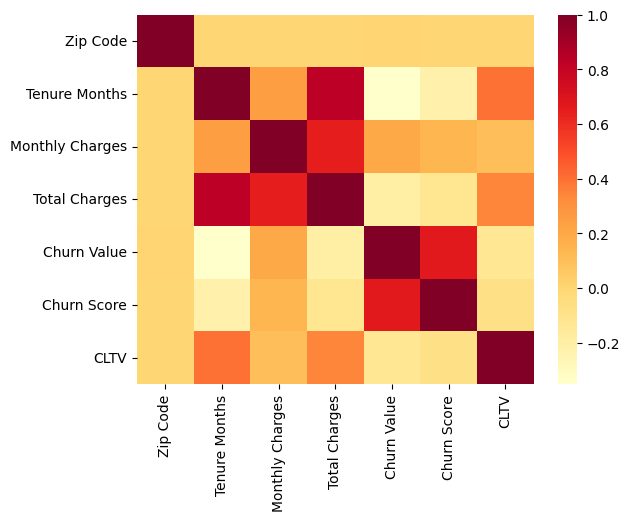

In [ ]:
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), cmap='YlOrRd')

Odrzucamy atrybut Total Charges ze względu na silną korelację z Tenure Months - nie będzie on informatywny

In [ ]:
df = df.drop(["Total Charges"], axis=1)
len(df.columns)

23

In [ ]:
df.describe(include=['object'])

,Gender,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Churn Reason
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,21
top,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Not provided.
freq,3555,5901,3641,5416,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


In [ ]:
df.describe(include=[np.number])

,Zip Code,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,93521.964646,32.371149,64.761692,0.265370,58.699418,4400.295755
std,1865.794555,24.559481,30.090047,0.441561,21.525131,1183.057152
min,90001.000000,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,92102.000000,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,93552.000000,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,95351.000000,55.000000,89.850000,1.000000,75.000000,5380.500000
max,96161.000000,72.000000,118.750000,1.000000,100.000000,6500.000000


### **4. Identyfikacja i odrzucenie pomiarów odstających**

**Z użyciem IQR**

In [ ]:
for column in df.select_dtypes(include=['number']).columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df

,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Value,Churn Score,CLTV,Churn Reason
0,90003,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,1,86,3239,Competitor made better offer
1,90005,Female,No,No,Yes,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,1,67,2701,Moved
2,90006,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,1,86,5372,Moved
3,90010,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,1,84,5003,Moved
4,90015,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,1,89,5340,Competitor had better devices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,92285,Female,No,No,No,72,Yes,No,No,No internet service,...,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,0,45,5306,Not provided.
7039,92301,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,One year,Yes,Mailed check,84.80,0,59,2140,Not provided.
7040,92304,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,Yes,One year,Yes,Credit card (automatic),103.20,0,71,5560,Not provided.
7041,92305,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.60,0,59,2793,Not provided.


array([[<Axes: title={'center': 'Zip Code'}>,
        <Axes: title={'center': 'Tenure Months'}>],
       [<Axes: title={'center': 'Monthly Charges'}>,
        <Axes: title={'center': 'Churn Value'}>],
       [<Axes: title={'center': 'Churn Score'}>,
        <Axes: title={'center': 'CLTV'}>]], dtype=object)

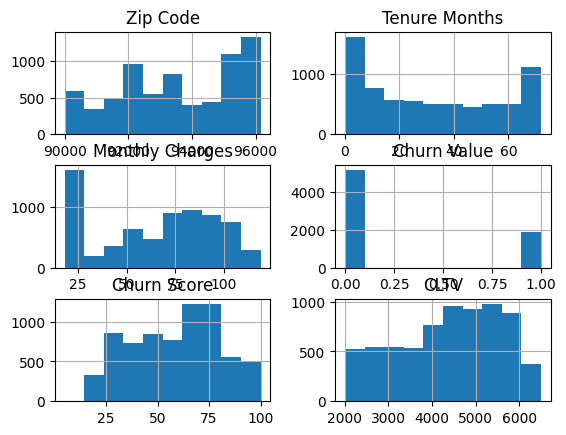

In [ ]:
df.hist()

### **5. Przygotowanie atrybutów o konkretnym typie do eksploracji**

**Zamiana Churn Value na target**

In [ ]:
df.columns

Index(['Zip Code', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Churn Value', 'Churn Score',
       'CLTV', 'Churn Reason'],
      dtype='object')

In [ ]:
df.rename(columns={'Churn Value':'target'}, inplace=True)

In [ ]:
df.columns

Index(['Zip Code', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'target', 'Churn Score', 'CLTV',
       'Churn Reason'],
      dtype='object')

**Mapowanie label encoding, zmiennych kategorialnych na numeryczne**

In [ ]:
encoder = LabelEncoder()
df_encoded = df.copy()
label_mappings = {}

for column in df.select_dtypes(include=['object']).columns:
    df_encoded[column] = encoder.fit_transform(df[column])
    label_mappings[column] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    label_mappings_int = {
        key: {k: int(v) for k, v in value.items()}
        for key, value in label_mappings.items()
    }

In [ ]:
print("\nMapowanie etykiet:")
for column, mapping in label_mappings_int.items():
    print(f"{column}: {mapping}")


Mapowanie etykiet:
Gender: {'Female': 0, 'Male': 1}
Senior Citizen: {'No': 0, 'Yes': 1}
Partner: {'No': 0, 'Yes': 1}
Dependents: {'No': 0, 'Yes': 1}
Phone Service: {'No': 0, 'Yes': 1}
Multiple Lines: {'No': 0, 'No phone service': 1, 'Yes': 2}
Internet Service: {'DSL': 0, 'Fiber optic': 1, 'No': 2}
Online Security: {'No': 0, 'No internet service': 1, 'Yes': 2}
Online Backup: {'No': 0, 'No internet service': 1, 'Yes': 2}
Device Protection: {'No': 0, 'No internet service': 1, 'Yes': 2}
Tech Support: {'No': 0, 'No internet service': 1, 'Yes': 2}
Streaming TV: {'No': 0, 'No internet service': 1, 'Yes': 2}
Streaming Movies: {'No': 0, 'No internet service': 1, 'Yes': 2}
Contract: {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
Paperless Billing: {'No': 0, 'Yes': 1}
Payment Method: {'Bank transfer (automatic)': 0, 'Credit card (automatic)': 1, 'Electronic check': 2, 'Mailed check': 3}
Churn Reason: {'Attitude of service provider': 0, 'Attitude of support person': 1, 'Competitor had better

In [ ]:
df_encoded.describe()

,Zip Code,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,target,Churn Score,CLTV,Churn Reason
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,93521.964646,0.504756,0.162147,0.483033,0.231010,32.371149,0.903166,0.940508,0.872923,0.790004,...,0.985376,0.992475,0.690473,0.592219,1.574329,64.761692,0.265370,58.699418,4400.295755,13.085759
std,1865.794555,0.500013,0.368612,0.499748,0.421508,24.559481,0.295752,0.948554,0.737796,0.859848,...,0.885002,0.885091,0.833755,0.491457,1.068104,30.090047,0.441561,21.525131,1183.057152,4.562205
min,90001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,5.000000,2003.000000,0.000000
25%,92102.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,35.500000,0.000000,40.000000,3469.000000,15.000000
50%,93552.000000,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,70.350000,0.000000,61.000000,4527.000000,15.000000
75%,95351.000000,1.000000,0.000000,1.000000,0.000000,55.000000,1.000000,2.000000,1.000000,2.000000,...,2.000000,2.000000,1.000000,1.000000,2.000000,89.850000,1.000000,75.000000,5380.500000,15.000000
max,96161.000000,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000,1.000000,100.000000,6500.000000,20.000000


### **6. Wybór miar ewaluacji**

**Kluczowe miary ewaluacji dla naszego problemu:**


*   accuracy - odsetek poprawnie sklasyfikowanych przykładów -> Accuracy = (TP + TN) / (TP + TN + FP + FN)
*   recall - ilu z tych którzy faktycznie odeszli udało się wykryć (chcemy wykrywać jak najwięcej odejść i móc na nie jakoś zareagować) -> Recall = TP / (TP + FN)
*   precision - z tych, których przewidziano jako rezygnujących, ilu rzeczywiście odeszło (może wskazywać czy nie wystąpi problem z "fałszywym alarmem") -> Precision = TP / (TP + FP)



### **7. Wstępny wybór algorytmu eksploracji danych**

klasyfikacja klasy target:

1 - zrezygnował,

0 - nie zrezygnował

**Wyznaczenie atrybutu z najwyższą korelacją z target - wstępna analiza**

In [ ]:
correlations = df.corr(numeric_only=True)['target'].drop('target')
most_correlated_feature = correlations.abs().idxmax()
correlation_value = correlations[most_correlated_feature]
print("Column name:", most_correlated_feature, "correlation with target:", correlation_value)

Column name: Churn Score correlation with target: 0.6648970311816286


Jak widać, atrybut Churn Score może mieć kluczowy wpływ na rezygnację klienta. Korelacja stanowi prostą, choć ograniczoną miarę zależności, którą można wykorzystać w klasyfikacji.